In [18]:
# TODO make the same thing with classes karmedexperiment and karmedcompetition
# TODO implement proper graphs using a custom wrapper (preferred) or 
# individually designed plots like in the former version 
# rl-specialization-coursera.exercises
# TODO think of implement multicore version
# runtimes for 1e6 iterations measured 20250206, 9 am
# @ThinkPad: 25.4s
# @ThinkPad old approach with 2 cores: 27.5s
# @ThinkPad old approach with 6 cores: 11.4s (only p-cores?)
# @ThinkPad old approach with 16 cores: 8.9s (p- and e-cores)

# training a basic agent

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from karmedbandit import BanditEnv
from karmedagents import BanditAgent

episodes = 1_000
timesteps = 1_000

env = gym.make("BanditEnv-v0")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes*timesteps)
# env.random_seed = 42

obs, info = env.reset(options=timesteps)
print(f'Initial bandit arms q-values:{env.get_wrapper_attr("arms_q_values")}')

agent = BanditAgent(env=env, policy="random")

for episode in tqdm(range(episodes)):
    obs, info = env.reset(options=timesteps)
    done = False 

    while not done:  # Perform some steps
        action = agent.get_action() #Example
        obs, reward, terminated, truncated, info = env.step(action)
        agent.update(reward)
        done = True if terminated or truncated else False

print(f'Final bandit arms q-values:{env.get_wrapper_attr("arms_q_values")}')

# env.close()

-------------------------
Bandit configuration
-------------------------
bandit_actions: 10
true_q_value_mean: 0.5
true_q_value_std: 0.0
q_value_std: 0.1
q_drift_mean: 0.0
q_drift_std: 0.0
random_seed: None
-------------------------
Initial bandit arms q-values:[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]

Final bandit arms q-values:[0.56506469 0.56828384 0.5456391  0.47805716 0.41634684 0.61281976
 0.56223214 0.35877765 0.57227864 0.51297717]


In [4]:
print(env.return_queue, env.length_queue)
# print(env.return_queue[500])
print(agent.training_error[500])
# print(np.ones(100))

deque([], maxlen=100000) deque([], maxlen=100000)
0.04700098071727382


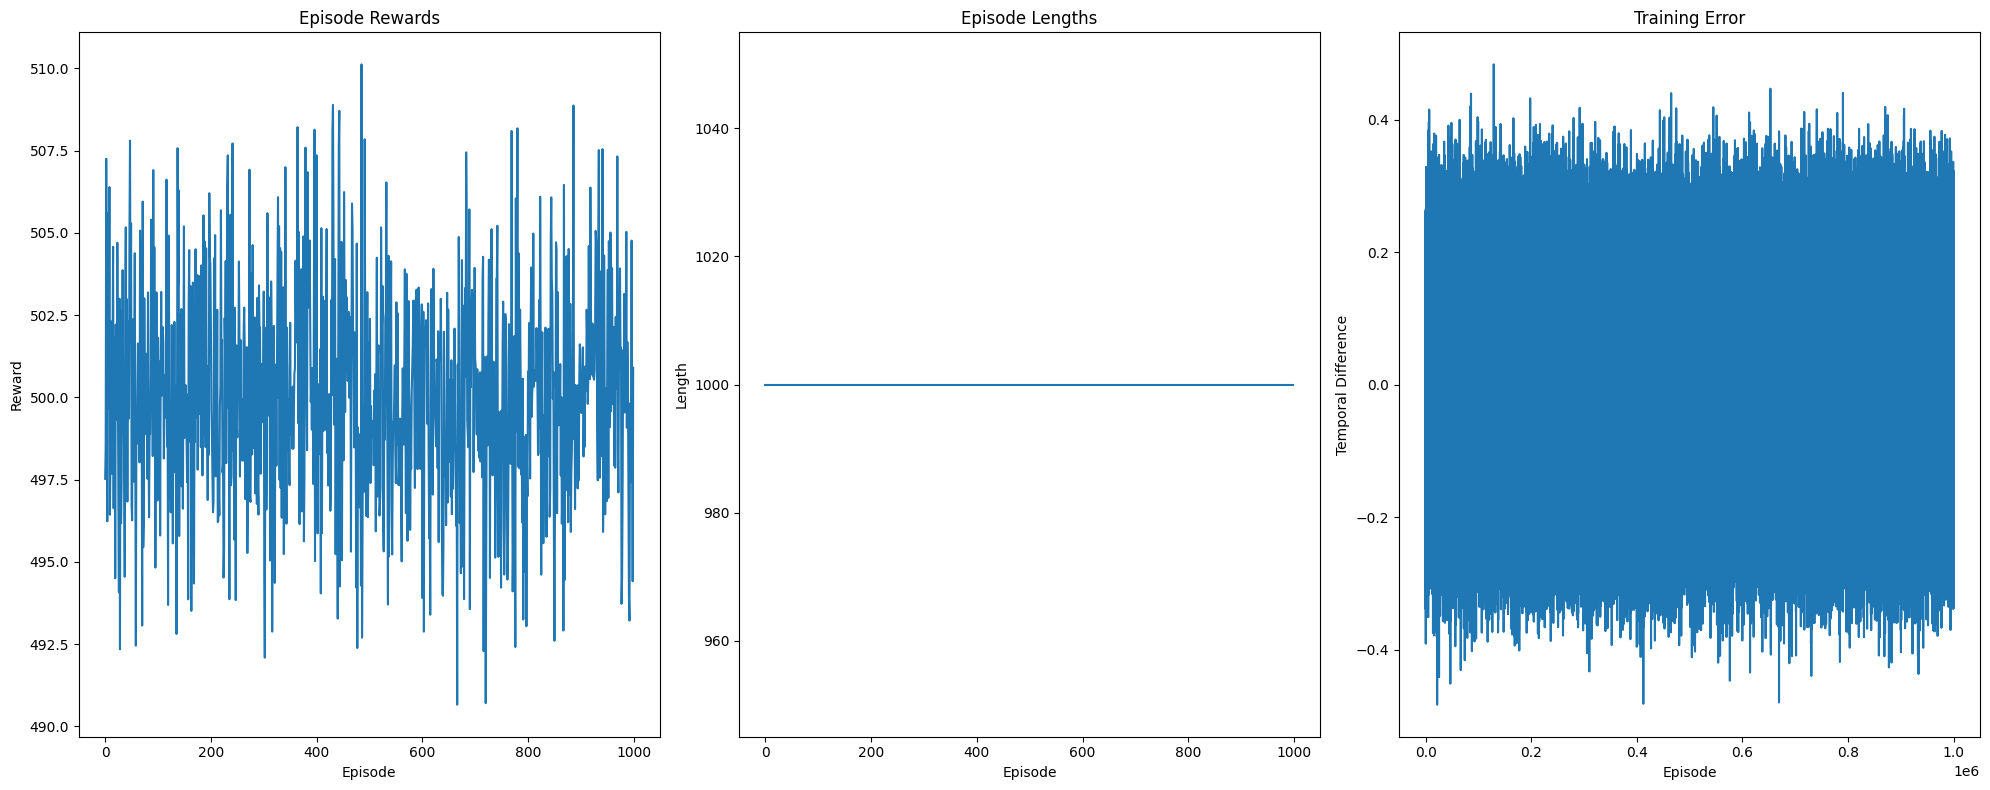

In [23]:
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

# TODO the convolve doesn't work
# axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].plot(env.return_queue)
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

# axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].plot(env.length_queue)
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

# axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].plot(agent.training_error)
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

# env.close()

In [14]:
# testing whether the env instantiation and use works in .ipynb

from karmedbandit import BanditEnv
env = BanditEnv()

# XXX info: gymnasium env self test. Run as required.
# The output in the terminal will indicate whether tests passed or failed.
# check_env(env = env)

print(env.true_q_value_mean)
obs, info = env.reset()
print("Initial arms_q_values:", env.arms_true_q_values)
print ("#"*79)
for _ in range(10_000):  # Perform some steps
    action = env.action_space.sample() #Example
    obs, reward, terminated, truncated, info = env.step(action)

print("Updated arms_q_values:", np.round(env.arms_q_values, 3))

env.close()

-------------------------
Bandit configuration
-------------------------
bandit_actions: 10
true_q_value_mean: 0.5
true_q_value_std: 0.0
q_value_std: 0.0
q_drift_mean: 0.0
q_drift_std: 0.01
random_seed: None
-------------------------
0.5
Initial arms_q_values: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
###############################################################################
Updated arms_q_values: [ 0.352 -0.475 -0.28   1.495  0.343  1.983 -0.357  2.195  0.813  2.212]


In [13]:
#testing the arms_true_q_values creation works properly
import numpy as np
bandit_actions = 10

bandit_actions: int = 10
true_q_value_mean = 0.5, # 
true_q_value_std = 0., # for a uniform initial q-value set this to zero

arms_true_q_values = np.random.normal(true_q_value_mean, true_q_value_std, bandit_actions)

print(arms_true_q_values)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [9]:
# testing the ingest of BanditParams into BanditEnv

import inspect

import gymnasium as gym

class BanditParams:
    arms: int = 10
    qdrift_mean: float = 0.0
    qdrift_std: float = 0.0
    stationary: bool = True

class BanditEnv(gym.Env, BanditParams):

    metadata = {"render_modes": ["human"], "render_fps": 4}
    
    def __init__(self):
        super().__init__()
        pass

env = BanditEnv()
# print(env.arms)
# env.arms = 6
# print(env.arms)

print(*[f"{key}: {value}" for key, value in env.__dict__.items()], sep="\n")

0.70125 1.275


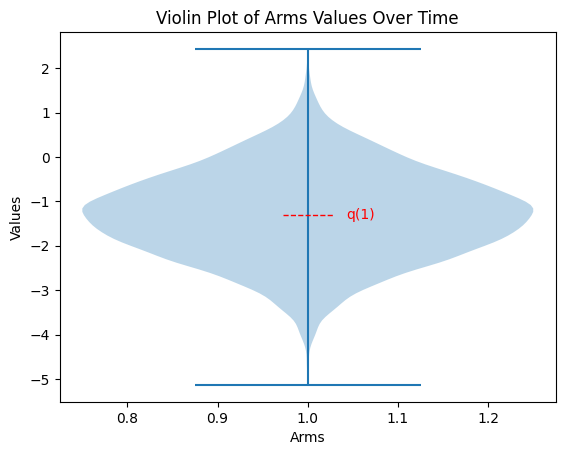

In [15]:
# Testing a violin chart to represent a distribution

'''Figure 2.1: An example bandit problem from the 10-armed testbed. The true value q⇤(a) of
each of the ten actions was selected according to a normal distribution with mean zero and unit
variance, and then the actual rewards were selected according to a mean q⇤(a), unit-variance
normal distribution, as suggested by these gray distributions.'''

import matplotlib.pyplot as plt
import numpy as np

# Generate the data
arms = 10
arms_q_values = np.random.normal(0, 1, arms)
timesteps = 10000
arms_values_over_time = np.zeros(timesteps)

arm = np.min(arms_q_values)
for i in range(timesteps):
    arms_values_over_time[i] = np.random.normal(arm, 1)

# Create a violin plot based on the data in arms_values_over_time
plt.violinplot(arms_values_over_time)
plt.title('Violin Plot of Arms Values Over Time')
plt.xlabel('Arms')
plt.ylabel('Values')

# Calculate the mean of the distribution
mean_value = np.mean(arms_values_over_time)

# Add a shorter marker/error line for the mean of the distribution
plt.axhline(mean_value, color='r', linestyle='--', linewidth=1, xmin=0.45, xmax=0.55)

# Get the current axis
ax = plt.gca()

# Get the right end of the error line
xmax = ax.get_xlim()[1] * 0.55
print (xmax, ax.get_xlim()[1])

# Add text relative to the right end of the error line
plt.text(1.45 * xmax + 0.02 * ax.get_xlim()[1], mean_value, f'q({np.argmin(arms_q_values)})', color='r', verticalalignment='center')

# Show the plot
plt.show()